# Обучаем нейросеть для предсказания рейтинга поста

Сегодня мы займёмся тем, что собственноучно обучим нейросеть на датасете постов с Пикабу, который мы подготовили в прошлом воркшопе.

На примере этой задачи посмотрим на разные оптимизаторы.

In [2]:
#!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/ed/b6/62345568cd07de5d9254fcf64d7e44aacbb6abde11ea953b3cb320e58d19/tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.17.0 from https://files.pythonhosted.org/packages/66/03/5c447feceb72f5a38ac2aa79d306fa5b5772f982c2b480c1329c7e382900/tensorflow_intel-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [25]:
# если вы уже используете GPU, есть смысл сказать Tensorflow,
# чтобы он не съедал сразу всю видеопамять,
# не будем перенапрягать видеокарту
GPUs = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(GPUs[0], True)

# если вы работаете на CPU, эта настройка не нужна

IndexError: list index out of range

In [26]:
# сразу зафиксируем сид для лучшей воспроизводимости результата
np.random.seed(17)
tf.random.set_seed(17)

Вспомним наш датасет

In [27]:
df = pd.read_csv('prepared_posts_df.csv')

In [28]:
df.head()

,nsfw,my,images,videos,text_len,rating,tsin,tcos,in_comm,Длиннопост,...,Своими руками,My Little Pony,Музыка,Мошенничество,Отношения,Стихи,Зима,СССР,Еда,other
0,0,1,2,0,135,683,-0.705620,0.708590,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,113,480,-0.705414,0.708795,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,301,-0.704950,0.709257,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,4,0,0,425,-0.704537,0.709667,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,726,617,-0.704021,0.710179,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# создадим матрицы признаков и ответов
X = df.drop(columns=['rating']).to_numpy()
Y = df['rating'].to_numpy()

Для обучения разделим наш датасет на 3 части: тренировочную, валидационную и тестовую.

* на тренировочной выборке мы будем обучать нашу нейросеть

* по валидационной выборке будем судить о том, как нейросеть работает с новыми данными и подбирать гиперпараметры

* тестовую выборку откладываем куда подальше: она нужна, чтобы проверить модель уже после того, как она окончательно доделана

In [30]:
# разделим датасет на части: тренировочную, валидационную и тестовую (в пропорции 70/15/15)
# это можно сделать как специальными функциями в фреймворках, так и обычными слайсами

val_frac = 0.15
test_frac = 0.15

x_train = X[:round((1 - val_frac - test_frac) * len(X))]
x_val = X[round((1 - val_frac - test_frac) * len(X)):round((1 - test_frac) * len(X))]
x_test = X[round((1 - test_frac) * len(X)):]

y_train = Y[:round((1 - val_frac - test_frac) * len(Y))]
y_val = Y[round((1 - val_frac - test_frac) * len(Y)):round((1 - test_frac) * len(Y))]
y_test = Y[round((1 - test_frac) * len(Y)):]

In [31]:
x_train.shape, x_val.shape, x_test.shape

((183804, 59), (39386, 59), (39387, 59))

## Строим нашу сетку

По-прежнему будем использовать полносвязную нейросеть, но в этот раз попробуем сделать её побольше. В качестве акцивации используем ReLU, а на последнем слое - линейную, ведь у нас задача регрессии.

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 200)                 │          12,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 500)                 │         100,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 200)                 │         100,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 223,271 (872.15 KB)

 Trainable params: 223,271 (872.15 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# сохраним начальные веса, чтобы в дальнейшем стартовать из одной точки
model.save_weights('initial_weights_59-200-500-200-50-10-1.weights.h5')

Чтобы обучить модель, сначала её нужно скомпилировать: указать параметры тренировки.

В первую очередь, конечно же, нужно выбрать функцию потерь. Т.к. у нас задача регрессии, а последний слой имеет линейную функцию активации, логично будет взять в качестве лосса MSE.

Оптимизировать нейросеть будем при помощи алгоритма Adam. В большинстве случаев он уже неплохо работает "из коробки" и не особо прихотлив в настройках. 

Если в процессе обучения мы хотим оценивать результат по каким-то дополнительным метрикам (помимо лосса), можно указать и их. Давайте на всякий случай ещё будем смотреть на MAE и RMSE.

In [34]:
# компилируем модель

model.compile(
    # указываем функцию потерь
    loss=tf.keras.losses.MSE,

    # выбираем оптимизатор
    optimizer=tf.keras.optimizers.Adam(),

    # можно указать метрики, которые будут считаться на каждом батче
    # и в конце эпохи на трейне и валидации
    # в качестве метрики может выступать и какой-нибудь loss
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

Всё готово для обучения!

По традиции модель обучается методом `fit`. В параметрах, помимо самих обучающих данных, можно также указать данные для валидации: после каждой эпохи мы будем смотреть, как модель ведёт себя на них.

Для начала попробуем сделать 100 проходов (эпох).

In [35]:
# метод fit может вернуть данные о процессе обучения
# по которым удобно анализировать лосс и метрики
history = model.fit(x_train, y_train,
                    # добавим данные для валидации
                    # модель не будет на них тренироваться, но будет считать на них лосс и метрики
                    # по валидации можно отлавливать оверфиттинг прямо во время обучения
                    validation_data=(x_val, y_val),

                    # размер батча данных, пропускаемых через граф за раз
                    # выбирайте из соображений доступной памяти
                    # (или видеопамяти, если используете GPU)
                    batch_size=50000,

                    # эпоха обучения - один проход по всем данным (батчами)
                    epochs=100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - loss: 396304.3438 - mean_absolute_error: 442.3768 - root_mean_squared_error: 629.1981 - val_loss: 359700.2812 - val_mean_absolute_error: 448.6346 - val_root_mean_squared_error: 599.7502
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - loss: 359273.7500 - mean_absolute_error: 446.5187 - root_mean_squared_error: 599.3859 - val_loss: 350293.4375 - val_mean_absolute_error: 432.2491 - val_root_mean_squared_error: 591.8559
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - loss: 349644.6875 - mean_absolute_error: 431.6768 - root_mean_squared_error: 591.3054 - val_loss: 344742.0625 - val_mean_absolute_error: 435.2300 - val_root_mean_squared_error: 587.1474
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - loss: 346084.1875 - mean_absolute_error: 435.3751 - root_mean_squared_error: 588.2877 - val_loss: 345327.2812 - val_mean_absolute_error: 432.1684 - val_root_mean_squared_error: 587.6456
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 373m

Epoch 31/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - loss: 319282.4375 - mean_absolute_error: 391.7133 - root_mean_squared_error: 565.0493 - val_loss: 318007.6250 - val_mean_absolute_error: 392.7625 - val_root_mean_squared_error: 563.9216
Epoch 32/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - loss: 318981.3438 - mean_absolute_error: 391.7621 - root_mean_squared_error: 564.7827 - val_loss: 317258.4375 - val_mean_absolute_error: 390.2919 - val_root_mean_squared_error: 563.2570
Epoch 33/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - loss: 317769.4375 - mean_absolute_error: 390.1535 - root_mean_squared_error: 563.7087 - val_loss: 315830.2500 - val_mean_absolute_error: 388.3178 - val_root_mean_squared_error: 561.9878
Epoch 34/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - loss: 316350.5000 - mean_absolute_error: 387.4943 - root_mean_squared_error: 562.4487 - val_loss: 314015.5625 - val_mean_absolute_error: 386.5448 - val_root_mean_squared_error: 560.3709
Epoch 35/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s

Epoch 61/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - loss: 185597.7344 - mean_absolute_error: 261.1216 - root_mean_squared_error: 430.6733 - val_loss: 310298.2188 - val_mean_absolute_error: 362.2067 - val_root_mean_squared_error: 557.0442
Epoch 62/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - loss: 321139.3438 - mean_absolute_error: 367.6075 - root_mean_squared_error: 566.6725 - val_loss: 342570.8750 - val_mean_absolute_error: 389.3379 - val_root_mean_squared_error: 585.2955
Epoch 63/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - loss: 339857.9688 - mean_absolute_error: 383.9157 - root_mean_squared_error: 582.9650 - val_loss: 324422.9688 - val_mean_absolute_error: 377.1185 - val_root_mean_squared_error: 569.5814
Epoch 64/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - loss: 316990.8750 - mean_absolute_error: 368.3887 - root_mean_squared_error: 562.9877 - val_loss: 284135.3125 - val_mean_absolute_error: 348.3061 - val_root_mean_squared_error: 533.0435
Epoch 65/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s

Epoch 91/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - loss: 247271.6562 - mean_absolute_error: 316.4847 - root_mean_squared_error: 497.2587 - val_loss: 243311.5625 - val_mean_absolute_error: 316.5192 - val_root_mean_squared_error: 493.2662
Epoch 92/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step - loss: 241349.6250 - mean_absolute_error: 312.0361 - root_mean_squared_error: 491.2647 - val_loss: 234106.2500 - val_mean_absolute_error: 306.4853 - val_root_mean_squared_error: 483.8453
Epoch 93/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - loss: 231924.5156 - mean_absolute_error: 301.5313 - root_mean_squared_error: 481.5786 - val_loss: 227130.1406 - val_mean_absolute_error: 296.4822 - val_root_mean_squared_error: 476.5817
Epoch 94/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - loss: 223473.5000 - mean_absolute_error: 292.1586 - root_mean_squared_error: 472.7208 - val_loss: 215022.8438 - val_mean_absolute_error: 288.6777 - val_root_mean_squared_error: 463.7056
Epoch 95/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s



В объекте `history` у нас сохранились данные о значениях лосса и метрик на каждой эпохе. Давайте на них посмотрим:

In [36]:
import matplotlib.pyplot as plt

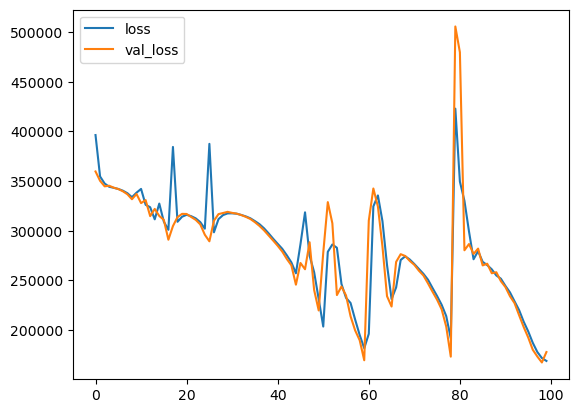

In [37]:
# посмотрим, как оптимизируется функция потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Видим, что значение лосса сильно скачет, при этом не особо спешит идти вниз.

Такое поведение может свидетельствовать о слишком большом learning rate: алгоритм делает большие шаги и "скачет" вокруг какой-то ямки, но всё никак в неё не попадёт. Скорее всего, рано или поздно Adam и сам адаптирует lr, но мы можем ему немного помочь...

In [38]:
# перекомпилируем модель с более низким lr и продолжим обучение
model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

history2 = model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     batch_size=50000,
                     epochs=100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - loss: 177724.0000 - mean_absolute_error: 253.6757 - root_mean_squared_error: 421.5466 - val_loss: 166977.5000 - val_mean_absolute_error: 248.3336 - val_root_mean_squared_error: 408.6288
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - loss: 170008.0000 - mean_absolute_error: 248.8548 - root_mean_squared_error: 412.3105 - val_loss: 164804.8594 - val_mean_absolute_error: 246.0503 - val_root_mean_squared_error: 405.9616
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - loss: 167162.7656 - mean_absolute_error: 246.5110 - root_mean_squared_error: 408.8489 - val_loss: 162368.5938 - val_mean_absolute_error: 244.6320 - val_root_mean_squared_error: 402.9499
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 165907.1875 - mean_absolute_error: 245.7674 - root_mean_squared_error: 407.3118 - val_loss: 161130.5938 - val_mean_absolute_error: 243.5049 - val_root_mean_squared_error: 401.4108
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 363m

Epoch 31/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - loss: 153932.2188 - mean_absolute_error: 236.5596 - root_mean_squared_error: 392.3369 - val_loss: 150611.0938 - val_mean_absolute_error: 235.3704 - val_root_mean_squared_error: 388.0865
Epoch 32/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 153496.5312 - mean_absolute_error: 236.2212 - root_mean_squared_error: 391.7802 - val_loss: 150833.8438 - val_mean_absolute_error: 235.3704 - val_root_mean_squared_error: 388.3733
Epoch 33/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - loss: 153738.6719 - mean_absolute_error: 236.3314 - root_mean_squared_error: 392.0887 - val_loss: 150385.4688 - val_mean_absolute_error: 235.1478 - val_root_mean_squared_error: 387.7957
Epoch 34/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - loss: 153373.4531 - mean_absolute_error: 236.0295 - root_mean_squared_error: 391.6236 - val_loss: 150426.8438 - val_mean_absolute_error: 235.0041 - val_root_mean_squared_error: 387.8490
Epoch 35/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s

Epoch 61/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - loss: 151297.2656 - mean_absolute_error: 233.4915 - root_mean_squared_error: 388.9629 - val_loss: 148560.4219 - val_mean_absolute_error: 232.7092 - val_root_mean_squared_error: 385.4354
Epoch 62/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 380ms/step - loss: 151240.0156 - mean_absolute_error: 233.4167 - root_mean_squared_error: 388.8895 - val_loss: 148530.7344 - val_mean_absolute_error: 232.6201 - val_root_mean_squared_error: 385.3969
Epoch 63/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - loss: 151141.3750 - mean_absolute_error: 233.2845 - root_mean_squared_error: 388.7625 - val_loss: 148436.1094 - val_mean_absolute_error: 232.5608 - val_root_mean_squared_error: 385.2741
Epoch 64/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - loss: 151109.3281 - mean_absolute_error: 233.2678 - root_mean_squared_error: 388.7214 - val_loss: 148396.0156 - val_mean_absolute_error: 232.4834 - val_root_mean_squared_error: 385.2220
Epoch 65/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s

Epoch 91/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - loss: 149198.0156 - mean_absolute_error: 230.6714 - root_mean_squared_error: 386.2545 - val_loss: 146683.5625 - val_mean_absolute_error: 230.0971 - val_root_mean_squared_error: 382.9929
Epoch 92/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - loss: 149381.2031 - mean_absolute_error: 230.8130 - root_mean_squared_error: 386.4925 - val_loss: 146711.1562 - val_mean_absolute_error: 230.0213 - val_root_mean_squared_error: 383.0289
Epoch 93/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - loss: 149110.1094 - mean_absolute_error: 230.5224 - root_mean_squared_error: 386.1406 - val_loss: 146555.3594 - val_mean_absolute_error: 229.9443 - val_root_mean_squared_error: 382.8255
Epoch 94/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - loss: 149229.0938 - mean_absolute_error: 230.6311 - root_mean_squared_error: 386.2956 - val_loss: 146649.7188 - val_mean_absolute_error: 229.8675 - val_root_mean_squared_error: 382.9487
Epoch 95/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s

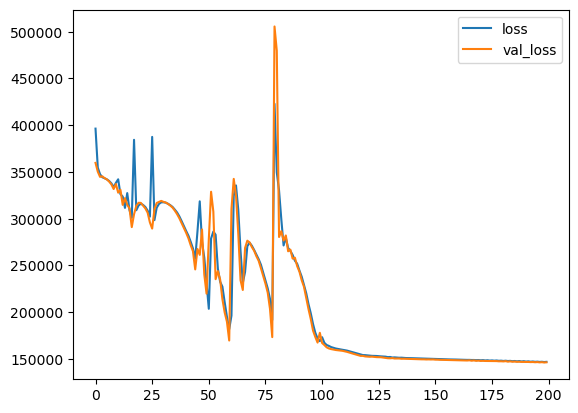

In [39]:
# посмотрим на новый график
plt.plot(history.history['loss'] + history2.history['loss'])
plt.plot(history.history['val_loss'] + history2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Выглядит просто отлично! Давайте продолжим обучение:

In [40]:
history3 = model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     batch_size=50000,
                     epochs=500)  # на этот раз побольше эпох

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - loss: 148658.0469 - mean_absolute_error: 229.8058 - root_mean_squared_error: 385.5545 - val_loss: 146040.5625 - val_mean_absolute_error: 229.2382 - val_root_mean_squared_error: 382.1525
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - loss: 148751.4219 - mean_absolute_error: 229.9243 - root_mean_squared_error: 385.6770 - val_loss: 146167.9062 - val_mean_absolute_error: 229.1581 - val_root_mean_squared_error: 382.3191
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - loss: 148502.4531 - mean_absolute_error: 229.6035 - root_mean_squared_error: 385.3528 - val_loss: 145913.6875 - val_mean_absolute_error: 229.0536 - val_root_mean_squared_error: 381.9865
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - loss: 148643.4062 - mean_absolute_error: 229.7533 - root_mean_squared_error: 385.5370 - val_loss: 146039.3906 - val_mean_absolute_error: 228.9588 - val_root_mean_squared_error: 382.1510
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 322m

Epoch 31/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 146568.0781 - mean_absolute_error: 226.6316 - root_mean_squared_error: 382.8342 - val_loss: 144042.4062 - val_mean_absolute_error: 226.1968 - val_root_mean_squared_error: 379.5292
Epoch 32/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - loss: 146784.5781 - mean_absolute_error: 226.8642 - root_mean_squared_error: 383.1191 - val_loss: 144107.8281 - val_mean_absolute_error: 226.0641 - val_root_mean_squared_error: 379.6154
Epoch 33/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - loss: 146298.2500 - mean_absolute_error: 226.3498 - root_mean_squared_error: 382.4819 - val_loss: 143960.1094 - val_mean_absolute_error: 225.9331 - val_root_mean_squared_error: 379.4207
Epoch 34/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - loss: 146681.8750 - mean_absolute_error: 226.6119 - root_mean_squared_error: 382.9849 - val_loss: 143832.8125 - val_mean_absolute_error: 225.8230 - val_root_mean_squared_error: 379.2530
Epoch 35/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s

Epoch 61/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - loss: 144622.9375 - mean_absolute_error: 223.1108 - root_mean_squared_error: 380.2835 - val_loss: 141764.2969 - val_mean_absolute_error: 222.6170 - val_root_mean_squared_error: 376.5160
Epoch 62/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - loss: 144464.9375 - mean_absolute_error: 223.1183 - root_mean_squared_error: 380.0799 - val_loss: 142089.9531 - val_mean_absolute_error: 222.4633 - val_root_mean_squared_error: 376.9482
Epoch 63/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - loss: 144091.6094 - mean_absolute_error: 222.6155 - root_mean_squared_error: 379.5858 - val_loss: 141693.9062 - val_mean_absolute_error: 222.3620 - val_root_mean_squared_error: 376.4225
Epoch 64/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - loss: 144555.6406 - mean_absolute_error: 223.0647 - root_mean_squared_error: 380.1992 - val_loss: 141526.1406 - val_mean_absolute_error: 222.4635 - val_root_mean_squared_error: 376.1996
Epoch 65/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s

Epoch 91/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - loss: 148711.7656 - mean_absolute_error: 223.9121 - root_mean_squared_error: 385.6231 - val_loss: 142753.2031 - val_mean_absolute_error: 223.5820 - val_root_mean_squared_error: 377.8269
Epoch 92/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - loss: 148119.3750 - mean_absolute_error: 225.2508 - root_mean_squared_error: 384.8598 - val_loss: 141502.0469 - val_mean_absolute_error: 219.5496 - val_root_mean_squared_error: 376.1676
Epoch 93/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - loss: 147502.9062 - mean_absolute_error: 223.5464 - root_mean_squared_error: 384.0517 - val_loss: 146635.3906 - val_mean_absolute_error: 222.9168 - val_root_mean_squared_error: 382.9300
Epoch 94/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step - loss: 147503.0000 - mean_absolute_error: 222.6089 - root_mean_squared_error: 384.0493 - val_loss: 143987.5312 - val_mean_absolute_error: 220.9807 - val_root_mean_squared_error: 379.4569
Epoch 95/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s

Epoch 121/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 140504.1719 - mean_absolute_error: 214.1250 - root_mean_squared_error: 374.8266 - val_loss: 138255.9062 - val_mean_absolute_error: 213.2340 - val_root_mean_squared_error: 371.8278
Epoch 122/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - loss: 139860.0000 - mean_absolute_error: 213.5947 - root_mean_squared_error: 373.9672 - val_loss: 136313.5938 - val_mean_absolute_error: 211.9629 - val_root_mean_squared_error: 369.2067
Epoch 123/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - loss: 138888.8750 - mean_absolute_error: 212.5998 - root_mean_squared_error: 372.6709 - val_loss: 136943.1094 - val_mean_absolute_error: 213.9218 - val_root_mean_squared_error: 370.0583
Epoch 124/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - loss: 138429.0781 - mean_absolute_error: 212.5786 - root_mean_squared_error: 372.0524 - val_loss: 136514.1719 - val_mean_absolute_error: 211.5698 - val_root_mean_squared_error: 369.4782
Epoch 125/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 151/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - loss: 135110.4375 - mean_absolute_error: 205.7791 - root_mean_squared_error: 367.5676 - val_loss: 137200.2500 - val_mean_absolute_error: 207.7927 - val_root_mean_squared_error: 370.4055
Epoch 152/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - loss: 137092.8438 - mean_absolute_error: 206.8139 - root_mean_squared_error: 370.2430 - val_loss: 132826.9844 - val_mean_absolute_error: 204.5004 - val_root_mean_squared_error: 364.4544
Epoch 153/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - loss: 138305.7031 - mean_absolute_error: 208.0970 - root_mean_squared_error: 371.8889 - val_loss: 145724.0000 - val_mean_absolute_error: 222.1501 - val_root_mean_squared_error: 381.7381
Epoch 154/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - loss: 143313.6250 - mean_absolute_error: 214.5144 - root_mean_squared_error: 378.5444 - val_loss: 137527.9688 - val_mean_absolute_error: 211.2943 - val_root_mean_squared_error: 370.8476
Epoch 155/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 181/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - loss: 140245.5938 - mean_absolute_error: 210.3159 - root_mean_squared_error: 374.4864 - val_loss: 139907.0156 - val_mean_absolute_error: 208.2592 - val_root_mean_squared_error: 374.0415
Epoch 182/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - loss: 139846.5156 - mean_absolute_error: 206.8299 - root_mean_squared_error: 373.9464 - val_loss: 135233.0000 - val_mean_absolute_error: 204.1350 - val_root_mean_squared_error: 367.7404
Epoch 183/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 137999.8594 - mean_absolute_error: 204.6103 - root_mean_squared_error: 371.4761 - val_loss: 138034.8281 - val_mean_absolute_error: 209.7357 - val_root_mean_squared_error: 371.5304
Epoch 184/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - loss: 137455.8750 - mean_absolute_error: 206.2077 - root_mean_squared_error: 370.7374 - val_loss: 133450.9688 - val_mean_absolute_error: 202.2371 - val_root_mean_squared_error: 365.3094
Epoch 185/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 211/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - loss: 132565.9375 - mean_absolute_error: 198.7735 - root_mean_squared_error: 364.0874 - val_loss: 130040.8281 - val_mean_absolute_error: 197.3496 - val_root_mean_squared_error: 360.6118
Epoch 212/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 131708.9219 - mean_absolute_error: 197.5317 - root_mean_squared_error: 362.9085 - val_loss: 129731.9297 - val_mean_absolute_error: 196.8847 - val_root_mean_squared_error: 360.1832
Epoch 213/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 131325.6406 - mean_absolute_error: 197.0452 - root_mean_squared_error: 362.3793 - val_loss: 129607.3047 - val_mean_absolute_error: 196.4358 - val_root_mean_squared_error: 360.0101
Epoch 214/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step - loss: 130979.6094 - mean_absolute_error: 196.2803 - root_mean_squared_error: 361.9013 - val_loss: 129470.7969 - val_mean_absolute_error: 196.2022 - val_root_mean_squared_error: 359.8205
Epoch 215/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 241/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 170992.8438 - mean_absolute_error: 229.4240 - root_mean_squared_error: 413.4936 - val_loss: 149844.0312 - val_mean_absolute_error: 215.6134 - val_root_mean_squared_error: 387.0969
Epoch 242/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - loss: 162327.8906 - mean_absolute_error: 223.8927 - root_mean_squared_error: 402.8435 - val_loss: 146250.1406 - val_mean_absolute_error: 212.1542 - val_root_mean_squared_error: 382.4266
Epoch 243/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - loss: 149134.3438 - mean_absolute_error: 213.9496 - root_mean_squared_error: 386.1479 - val_loss: 153971.0312 - val_mean_absolute_error: 218.9164 - val_root_mean_squared_error: 392.3914
Epoch 244/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 150051.8906 - mean_absolute_error: 212.8505 - root_mean_squared_error: 387.3185 - val_loss: 149915.7031 - val_mean_absolute_error: 217.9164 - val_root_mean_squared_error: 387.1895
Epoch 245/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 271/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 537ms/step - loss: 128483.9766 - mean_absolute_error: 191.8496 - root_mean_squared_error: 358.4371 - val_loss: 126958.5703 - val_mean_absolute_error: 191.7805 - val_root_mean_squared_error: 356.3125
Epoch 272/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step - loss: 128311.7734 - mean_absolute_error: 191.6515 - root_mean_squared_error: 358.1973 - val_loss: 126730.4141 - val_mean_absolute_error: 191.5767 - val_root_mean_squared_error: 355.9922
Epoch 273/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step - loss: 128077.3750 - mean_absolute_error: 191.3905 - root_mean_squared_error: 357.8701 - val_loss: 126677.0234 - val_mean_absolute_error: 191.4059 - val_root_mean_squared_error: 355.9171
Epoch 274/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - loss: 127954.4062 - mean_absolute_error: 191.1920 - root_mean_squared_error: 357.6979 - val_loss: 126558.2109 - val_mean_absolute_error: 191.1372 - val_root_mean_squared_error: 355.7502
Epoch 275/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 301/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - loss: 126635.5547 - mean_absolute_error: 188.4804 - root_mean_squared_error: 355.8536 - val_loss: 123773.5000 - val_mean_absolute_error: 186.9306 - val_root_mean_squared_error: 351.8146
Epoch 302/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - loss: 125105.0391 - mean_absolute_error: 186.7221 - root_mean_squared_error: 353.6930 - val_loss: 124675.3125 - val_mean_absolute_error: 187.6831 - val_root_mean_squared_error: 353.0939
Epoch 303/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - loss: 126347.6875 - mean_absolute_error: 188.0110 - root_mean_squared_error: 355.4459 - val_loss: 123575.3203 - val_mean_absolute_error: 186.6076 - val_root_mean_squared_error: 351.5328
Epoch 304/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 523ms/step - loss: 124747.2031 - mean_absolute_error: 186.1950 - root_mean_squared_error: 353.1864 - val_loss: 123873.6328 - val_mean_absolute_error: 186.7315 - val_root_mean_squared_error: 351.9568
Epoch 305/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 331/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - loss: 131698.4375 - mean_absolute_error: 195.7914 - root_mean_squared_error: 362.8947 - val_loss: 129940.1016 - val_mean_absolute_error: 195.8346 - val_root_mean_squared_error: 360.4720
Epoch 332/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 131301.0469 - mean_absolute_error: 195.5484 - root_mean_squared_error: 362.3469 - val_loss: 129714.2891 - val_mean_absolute_error: 195.4494 - val_root_mean_squared_error: 360.1587
Epoch 333/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - loss: 131056.9766 - mean_absolute_error: 195.1526 - root_mean_squared_error: 362.0096 - val_loss: 129306.2734 - val_mean_absolute_error: 194.9477 - val_root_mean_squared_error: 359.5918
Epoch 334/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - loss: 130687.5000 - mean_absolute_error: 194.6195 - root_mean_squared_error: 361.4991 - val_loss: 129025.7578 - val_mean_absolute_error: 194.5954 - val_root_mean_squared_error: 359.2016
Epoch 335/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 361/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - loss: 126010.5703 - mean_absolute_error: 187.9841 - root_mean_squared_error: 354.9703 - val_loss: 124788.3047 - val_mean_absolute_error: 188.2898 - val_root_mean_squared_error: 353.2539
Epoch 362/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - loss: 125971.4453 - mean_absolute_error: 187.9078 - root_mean_squared_error: 354.9150 - val_loss: 124705.3984 - val_mean_absolute_error: 188.1489 - val_root_mean_squared_error: 353.1365
Epoch 363/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - loss: 125937.3125 - mean_absolute_error: 187.8107 - root_mean_squared_error: 354.8671 - val_loss: 124698.5469 - val_mean_absolute_error: 188.0723 - val_root_mean_squared_error: 353.1268
Epoch 364/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - loss: 125870.6250 - mean_absolute_error: 187.6558 - root_mean_squared_error: 354.7729 - val_loss: 124617.0781 - val_mean_absolute_error: 187.9162 - val_root_mean_squared_error: 353.0114
Epoch 365/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 391/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - loss: 148258.3125 - mean_absolute_error: 210.9879 - root_mean_squared_error: 385.0273 - val_loss: 157244.2188 - val_mean_absolute_error: 213.0483 - val_root_mean_squared_error: 396.5403
Epoch 392/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - loss: 145113.0938 - mean_absolute_error: 205.0379 - root_mean_squared_error: 380.8587 - val_loss: 131420.6250 - val_mean_absolute_error: 197.3458 - val_root_mean_squared_error: 362.5198
Epoch 393/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - loss: 135322.8750 - mean_absolute_error: 199.5125 - root_mean_squared_error: 367.8509 - val_loss: 133949.9375 - val_mean_absolute_error: 198.4763 - val_root_mean_squared_error: 365.9917
Epoch 394/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - loss: 133979.7969 - mean_absolute_error: 197.3373 - root_mean_squared_error: 366.0176 - val_loss: 131658.7969 - val_mean_absolute_error: 194.8109 - val_root_mean_squared_error: 362.8482
Epoch 395/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 421/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step - loss: 123126.3125 - mean_absolute_error: 183.2991 - root_mean_squared_error: 350.8843 - val_loss: 123204.4141 - val_mean_absolute_error: 185.7158 - val_root_mean_squared_error: 351.0049
Epoch 422/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - loss: 123637.3359 - mean_absolute_error: 184.0662 - root_mean_squared_error: 351.6071 - val_loss: 121689.2266 - val_mean_absolute_error: 183.3562 - val_root_mean_squared_error: 348.8398
Epoch 423/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - loss: 122991.7969 - mean_absolute_error: 183.1154 - root_mean_squared_error: 350.6941 - val_loss: 124491.8125 - val_mean_absolute_error: 187.6004 - val_root_mean_squared_error: 352.8340
Epoch 424/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - loss: 124254.4609 - mean_absolute_error: 184.8991 - root_mean_squared_error: 352.4799 - val_loss: 121706.8594 - val_mean_absolute_error: 183.0891 - val_root_mean_squared_error: 348.8651
Epoch 425/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 451/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - loss: 123952.4922 - mean_absolute_error: 184.7710 - root_mean_squared_error: 352.0587 - val_loss: 122750.7578 - val_mean_absolute_error: 184.9765 - val_root_mean_squared_error: 350.3580
Epoch 452/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - loss: 123850.4375 - mean_absolute_error: 184.5765 - root_mean_squared_error: 351.9145 - val_loss: 122608.1250 - val_mean_absolute_error: 184.9036 - val_root_mean_squared_error: 350.1544
Epoch 453/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - loss: 123570.2891 - mean_absolute_error: 184.2936 - root_mean_squared_error: 351.5161 - val_loss: 122739.7969 - val_mean_absolute_error: 185.0078 - val_root_mean_squared_error: 350.3424
Epoch 454/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - loss: 123763.1953 - mean_absolute_error: 184.4086 - root_mean_squared_error: 351.7900 - val_loss: 122515.9844 - val_mean_absolute_error: 184.5586 - val_root_mean_squared_error: 350.0228
Epoch 455/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 481/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - loss: 121764.6328 - mean_absolute_error: 181.4145 - root_mean_squared_error: 348.9378 - val_loss: 121428.0938 - val_mean_absolute_error: 183.1459 - val_root_mean_squared_error: 348.4653
Epoch 482/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - loss: 123081.0469 - mean_absolute_error: 183.1241 - root_mean_squared_error: 350.8219 - val_loss: 120909.2422 - val_mean_absolute_error: 182.1444 - val_root_mean_squared_error: 347.7201
Epoch 483/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - loss: 121682.4688 - mean_absolute_error: 181.2305 - root_mean_squared_error: 348.8199 - val_loss: 121007.4141 - val_mean_absolute_error: 182.4059 - val_root_mean_squared_error: 347.8612
Epoch 484/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - loss: 122932.1484 - mean_absolute_error: 182.8428 - root_mean_squared_error: 350.6106 - val_loss: 120862.5234 - val_mean_absolute_error: 181.9377 - val_root_mean_squared_error: 347.6529
Epoch 485/500
4/4 ━━━━━━━━━━━━━━━━━━

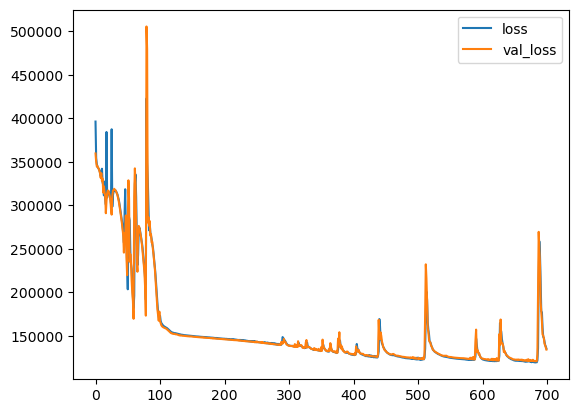

In [41]:
# посмотрим на новый график
plt.plot(history.history['loss'] + history2.history['loss'] + history3.history['loss'])
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Неплохо, но опять пошли небольшие скачки. Давайте ещё уменьшим lr, чтобы уже окончательно "дожать" нашу сетку.

In [42]:
# ещё уменьшим lr
model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

history4 = model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     batch_size=50000,
                     epochs=500)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - loss: 136348.3594 - mean_absolute_error: 203.0532 - root_mean_squared_error: 369.2463 - val_loss: 135419.5156 - val_mean_absolute_error: 201.7999 - val_root_mean_squared_error: 367.9939
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step - loss: 136323.2812 - mean_absolute_error: 200.6093 - root_mean_squared_error: 369.2094 - val_loss: 133631.9531 - val_mean_absolute_error: 201.8226 - val_root_mean_squared_error: 365.5570
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - loss: 134911.7969 - mean_absolute_error: 201.3266 - root_mean_squared_error: 367.2963 - val_loss: 132905.6719 - val_mean_absolute_error: 200.4529 - val_root_mean_squared_error: 364.5623
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - loss: 134010.4062 - mean_absolute_error: 199.1079 - root_mean_squared_error: 366.0665 - val_loss: 132561.3594 - val_mean_absolute_error: 198.6688 - val_root_mean_squared_error: 364.0898
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 698m

Epoch 31/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - loss: 124947.1328 - mean_absolute_error: 185.8994 - root_mean_squared_error: 353.4694 - val_loss: 123807.0391 - val_mean_absolute_error: 186.2941 - val_root_mean_squared_error: 351.8622
Epoch 32/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - loss: 124861.7266 - mean_absolute_error: 185.7465 - root_mean_squared_error: 353.3486 - val_loss: 123743.4688 - val_mean_absolute_error: 186.0854 - val_root_mean_squared_error: 351.7719
Epoch 33/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - loss: 124776.4141 - mean_absolute_error: 185.5543 - root_mean_squared_error: 353.2279 - val_loss: 123651.5625 - val_mean_absolute_error: 185.9895 - val_root_mean_squared_error: 351.6412
Epoch 34/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - loss: 124700.0781 - mean_absolute_error: 185.4474 - root_mean_squared_error: 353.1198 - val_loss: 123575.5312 - val_mean_absolute_error: 185.8466 - val_root_mean_squared_error: 351.5331
Epoch 35/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s

Epoch 61/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - loss: 123040.2656 - mean_absolute_error: 182.7913 - root_mean_squared_error: 350.7615 - val_loss: 121910.8594 - val_mean_absolute_error: 183.3018 - val_root_mean_squared_error: 349.1573
Epoch 62/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - loss: 123001.7891 - mean_absolute_error: 182.7389 - root_mean_squared_error: 350.7067 - val_loss: 121875.7734 - val_mean_absolute_error: 183.2569 - val_root_mean_squared_error: 349.1071
Epoch 63/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - loss: 122969.3594 - mean_absolute_error: 182.6907 - root_mean_squared_error: 350.6604 - val_loss: 121840.2422 - val_mean_absolute_error: 183.2168 - val_root_mean_squared_error: 349.0562
Epoch 64/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - loss: 122935.4609 - mean_absolute_error: 182.6434 - root_mean_squared_error: 350.6121 - val_loss: 121803.5625 - val_mean_absolute_error: 183.1723 - val_root_mean_squared_error: 349.0037
Epoch 65/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s

Epoch 91/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - loss: 121963.7031 - mean_absolute_error: 181.2990 - root_mean_squared_error: 349.2233 - val_loss: 120898.4297 - val_mean_absolute_error: 181.8437 - val_root_mean_squared_error: 347.7045
Epoch 92/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - loss: 121915.4766 - mean_absolute_error: 181.2309 - root_mean_squared_error: 349.1543 - val_loss: 120849.4688 - val_mean_absolute_error: 181.7673 - val_root_mean_squared_error: 347.6341
Epoch 93/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - loss: 121866.8672 - mean_absolute_error: 181.1607 - root_mean_squared_error: 349.0847 - val_loss: 120801.0312 - val_mean_absolute_error: 181.6823 - val_root_mean_squared_error: 347.5644
Epoch 94/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - loss: 121817.5469 - mean_absolute_error: 181.0819 - root_mean_squared_error: 349.0140 - val_loss: 120756.3281 - val_mean_absolute_error: 181.6057 - val_root_mean_squared_error: 347.5001
Epoch 95/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s

Epoch 121/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - loss: 121399.2266 - mean_absolute_error: 180.5130 - root_mean_squared_error: 348.4141 - val_loss: 120385.9609 - val_mean_absolute_error: 181.0657 - val_root_mean_squared_error: 346.9668
Epoch 122/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - loss: 121387.4688 - mean_absolute_error: 180.4963 - root_mean_squared_error: 348.3972 - val_loss: 120375.7969 - val_mean_absolute_error: 181.0493 - val_root_mean_squared_error: 346.9521
Epoch 123/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - loss: 121375.4219 - mean_absolute_error: 180.4792 - root_mean_squared_error: 348.3799 - val_loss: 120365.0859 - val_mean_absolute_error: 181.0316 - val_root_mean_squared_error: 346.9367
Epoch 124/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - loss: 121362.9062 - mean_absolute_error: 180.4623 - root_mean_squared_error: 348.3619 - val_loss: 120353.4766 - val_mean_absolute_error: 181.0135 - val_root_mean_squared_error: 346.9200
Epoch 125/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 151/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - loss: 120918.4609 - mean_absolute_error: 179.8469 - root_mean_squared_error: 347.7233 - val_loss: 119949.6719 - val_mean_absolute_error: 180.4224 - val_root_mean_squared_error: 346.3375
Epoch 152/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - loss: 120909.3125 - mean_absolute_error: 179.8302 - root_mean_squared_error: 347.7101 - val_loss: 119943.5234 - val_mean_absolute_error: 180.4114 - val_root_mean_squared_error: 346.3286
Epoch 153/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - loss: 120902.1484 - mean_absolute_error: 179.8191 - root_mean_squared_error: 347.6999 - val_loss: 119937.1250 - val_mean_absolute_error: 180.4016 - val_root_mean_squared_error: 346.3194
Epoch 154/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - loss: 120895.0703 - mean_absolute_error: 179.8095 - root_mean_squared_error: 347.6897 - val_loss: 119930.4453 - val_mean_absolute_error: 180.3913 - val_root_mean_squared_error: 346.3098
Epoch 155/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 181/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - loss: 120707.9844 - mean_absolute_error: 179.5256 - root_mean_squared_error: 347.4204 - val_loss: 119774.2266 - val_mean_absolute_error: 180.1198 - val_root_mean_squared_error: 346.0841
Epoch 182/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - loss: 120701.1016 - mean_absolute_error: 179.5145 - root_mean_squared_error: 347.4106 - val_loss: 119768.0391 - val_mean_absolute_error: 180.1121 - val_root_mean_squared_error: 346.0752
Epoch 183/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - loss: 120694.6719 - mean_absolute_error: 179.5061 - root_mean_squared_error: 347.4013 - val_loss: 119762.0859 - val_mean_absolute_error: 180.1054 - val_root_mean_squared_error: 346.0666
Epoch 184/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - loss: 120688.8516 - mean_absolute_error: 179.4993 - root_mean_squared_error: 347.3929 - val_loss: 119756.3125 - val_mean_absolute_error: 180.0985 - val_root_mean_squared_error: 346.0583
Epoch 185/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 211/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - loss: 120524.1406 - mean_absolute_error: 179.2497 - root_mean_squared_error: 347.1557 - val_loss: 119615.2422 - val_mean_absolute_error: 179.8558 - val_root_mean_squared_error: 345.8544
Epoch 212/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - loss: 120519.3594 - mean_absolute_error: 179.2426 - root_mean_squared_error: 347.1488 - val_loss: 119610.1094 - val_mean_absolute_error: 179.8452 - val_root_mean_squared_error: 345.8470
Epoch 213/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - loss: 120514.5156 - mean_absolute_error: 179.2340 - root_mean_squared_error: 347.1418 - val_loss: 119605.1406 - val_mean_absolute_error: 179.8336 - val_root_mean_squared_error: 345.8398
Epoch 214/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - loss: 120509.1016 - mean_absolute_error: 179.2249 - root_mean_squared_error: 347.1341 - val_loss: 119600.0703 - val_mean_absolute_error: 179.8249 - val_root_mean_squared_error: 345.8324
Epoch 215/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 241/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - loss: 120317.9844 - mean_absolute_error: 178.9447 - root_mean_squared_error: 346.8587 - val_loss: 119442.1797 - val_mean_absolute_error: 179.5488 - val_root_mean_squared_error: 345.6041
Epoch 242/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - loss: 120311.3750 - mean_absolute_error: 178.9346 - root_mean_squared_error: 346.8492 - val_loss: 119437.3594 - val_mean_absolute_error: 179.5383 - val_root_mean_squared_error: 345.5971
Epoch 243/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - loss: 120304.1719 - mean_absolute_error: 178.9226 - root_mean_squared_error: 346.8388 - val_loss: 119432.6875 - val_mean_absolute_error: 179.5279 - val_root_mean_squared_error: 345.5903
Epoch 244/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - loss: 120296.9844 - mean_absolute_error: 178.9102 - root_mean_squared_error: 346.8284 - val_loss: 119427.8906 - val_mean_absolute_error: 179.5181 - val_root_mean_squared_error: 345.5834
Epoch 245/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 271/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 120128.0391 - mean_absolute_error: 178.5814 - root_mean_squared_error: 346.5847 - val_loss: 119278.4531 - val_mean_absolute_error: 179.2005 - val_root_mean_squared_error: 345.3671
Epoch 272/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 120119.7656 - mean_absolute_error: 178.5640 - root_mean_squared_error: 346.5728 - val_loss: 119270.0156 - val_mean_absolute_error: 179.1830 - val_root_mean_squared_error: 345.3549
Epoch 273/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - loss: 120111.4141 - mean_absolute_error: 178.5461 - root_mean_squared_error: 346.5607 - val_loss: 119260.5078 - val_mean_absolute_error: 179.1607 - val_root_mean_squared_error: 345.3412
Epoch 274/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - loss: 120101.9219 - mean_absolute_error: 178.5249 - root_mean_squared_error: 346.5470 - val_loss: 119250.1406 - val_mean_absolute_error: 179.1355 - val_root_mean_squared_error: 345.3261
Epoch 275/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 301/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - loss: 119886.4375 - mean_absolute_error: 178.1932 - root_mean_squared_error: 346.2360 - val_loss: 119059.2031 - val_mean_absolute_error: 178.8051 - val_root_mean_squared_error: 345.0496
Epoch 302/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - loss: 119882.2969 - mean_absolute_error: 178.1867 - root_mean_squared_error: 346.2300 - val_loss: 119055.1562 - val_mean_absolute_error: 178.7975 - val_root_mean_squared_error: 345.0437
Epoch 303/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - loss: 119877.6094 - mean_absolute_error: 178.1796 - root_mean_squared_error: 346.2233 - val_loss: 119050.9609 - val_mean_absolute_error: 178.7927 - val_root_mean_squared_error: 345.0376
Epoch 304/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - loss: 119872.7734 - mean_absolute_error: 178.1745 - root_mean_squared_error: 346.2163 - val_loss: 119046.7500 - val_mean_absolute_error: 178.7873 - val_root_mean_squared_error: 345.0315
Epoch 305/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 331/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - loss: 119747.3438 - mean_absolute_error: 177.9692 - root_mean_squared_error: 346.0351 - val_loss: 118939.0469 - val_mean_absolute_error: 178.5933 - val_root_mean_squared_error: 344.8754
Epoch 332/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - loss: 119742.1953 - mean_absolute_error: 177.9610 - root_mean_squared_error: 346.0277 - val_loss: 118935.1875 - val_mean_absolute_error: 178.5844 - val_root_mean_squared_error: 344.8698
Epoch 333/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - loss: 119737.3125 - mean_absolute_error: 177.9506 - root_mean_squared_error: 346.0206 - val_loss: 118931.2031 - val_mean_absolute_error: 178.5781 - val_root_mean_squared_error: 344.8640
Epoch 334/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - loss: 119733.2188 - mean_absolute_error: 177.9442 - root_mean_squared_error: 346.0147 - val_loss: 118927.1484 - val_mean_absolute_error: 178.5720 - val_root_mean_squared_error: 344.8582
Epoch 335/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 361/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 119617.9375 - mean_absolute_error: 177.7385 - root_mean_squared_error: 345.8481 - val_loss: 118817.8516 - val_mean_absolute_error: 178.3618 - val_root_mean_squared_error: 344.6996
Epoch 362/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 119613.3281 - mean_absolute_error: 177.7299 - root_mean_squared_error: 345.8414 - val_loss: 118813.9609 - val_mean_absolute_error: 178.3548 - val_root_mean_squared_error: 344.6940
Epoch 363/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - loss: 119608.3828 - mean_absolute_error: 177.7213 - root_mean_squared_error: 345.8342 - val_loss: 118809.8828 - val_mean_absolute_error: 178.3482 - val_root_mean_squared_error: 344.6881
Epoch 364/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - loss: 119603.8594 - mean_absolute_error: 177.7130 - root_mean_squared_error: 345.8277 - val_loss: 118805.8359 - val_mean_absolute_error: 178.3414 - val_root_mean_squared_error: 344.6822
Epoch 365/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 391/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - loss: 119492.4219 - mean_absolute_error: 177.5070 - root_mean_squared_error: 345.6665 - val_loss: 118699.0078 - val_mean_absolute_error: 178.1373 - val_root_mean_squared_error: 344.5272
Epoch 392/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - loss: 119488.1641 - mean_absolute_error: 177.4979 - root_mean_squared_error: 345.6604 - val_loss: 118695.0859 - val_mean_absolute_error: 178.1288 - val_root_mean_squared_error: 344.5215
Epoch 393/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - loss: 119483.8516 - mean_absolute_error: 177.4891 - root_mean_squared_error: 345.6541 - val_loss: 118691.2734 - val_mean_absolute_error: 178.1217 - val_root_mean_squared_error: 344.5160
Epoch 394/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - loss: 119479.7812 - mean_absolute_error: 177.4814 - root_mean_squared_error: 345.6483 - val_loss: 118687.4531 - val_mean_absolute_error: 178.1143 - val_root_mean_squared_error: 344.5105
Epoch 395/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 421/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - loss: 119376.7578 - mean_absolute_error: 177.2836 - root_mean_squared_error: 345.4991 - val_loss: 118584.5703 - val_mean_absolute_error: 177.9202 - val_root_mean_squared_error: 344.3611
Epoch 422/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 558ms/step - loss: 119373.0547 - mean_absolute_error: 177.2775 - root_mean_squared_error: 345.4938 - val_loss: 118580.5312 - val_mean_absolute_error: 177.9156 - val_root_mean_squared_error: 344.3553
Epoch 423/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - loss: 119370.1016 - mean_absolute_error: 177.2739 - root_mean_squared_error: 345.4895 - val_loss: 118576.6406 - val_mean_absolute_error: 177.9093 - val_root_mean_squared_error: 344.3496
Epoch 424/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - loss: 119367.5547 - mean_absolute_error: 177.2695 - root_mean_squared_error: 345.4858 - val_loss: 118572.8984 - val_mean_absolute_error: 177.9000 - val_root_mean_squared_error: 344.3441
Epoch 425/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 451/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - loss: 119260.6250 - mean_absolute_error: 177.0641 - root_mean_squared_error: 345.3310 - val_loss: 118470.8672 - val_mean_absolute_error: 177.7056 - val_root_mean_squared_error: 344.1960
Epoch 452/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step - loss: 119256.6172 - mean_absolute_error: 177.0569 - root_mean_squared_error: 345.3252 - val_loss: 118466.9297 - val_mean_absolute_error: 177.7015 - val_root_mean_squared_error: 344.1902
Epoch 453/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step - loss: 119253.2188 - mean_absolute_error: 177.0519 - root_mean_squared_error: 345.3203 - val_loss: 118463.0781 - val_mean_absolute_error: 177.6962 - val_root_mean_squared_error: 344.1847
Epoch 454/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step - loss: 119249.8516 - mean_absolute_error: 177.0462 - root_mean_squared_error: 345.3154 - val_loss: 118459.3125 - val_mean_absolute_error: 177.6897 - val_root_mean_squared_error: 344.1792
Epoch 455/500
4/4 ━━━━━━━━━━━━━━━━━━

Epoch 481/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - loss: 119145.9062 - mean_absolute_error: 176.8548 - root_mean_squared_error: 345.1649 - val_loss: 118359.1250 - val_mean_absolute_error: 177.5105 - val_root_mean_squared_error: 344.0336
Epoch 482/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 119142.9766 - mean_absolute_error: 176.8484 - root_mean_squared_error: 345.1606 - val_loss: 118355.7188 - val_mean_absolute_error: 177.5036 - val_root_mean_squared_error: 344.0287
Epoch 483/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - loss: 119140.1328 - mean_absolute_error: 176.8435 - root_mean_squared_error: 345.1565 - val_loss: 118352.2188 - val_mean_absolute_error: 177.4951 - val_root_mean_squared_error: 344.0236
Epoch 484/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step - loss: 119136.7500 - mean_absolute_error: 176.8369 - root_mean_squared_error: 345.1516 - val_loss: 118348.9297 - val_mean_absolute_error: 177.4858 - val_root_mean_squared_error: 344.0188
Epoch 485/500
4/4 ━━━━━━━━━━━━━━━━━━

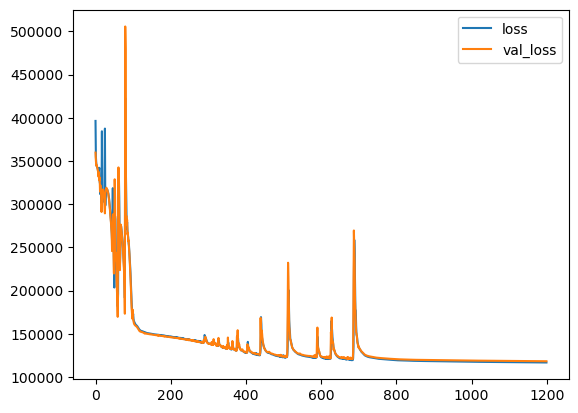

In [43]:
# посмотрим на новый график
plt.plot(history.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['loss'])
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

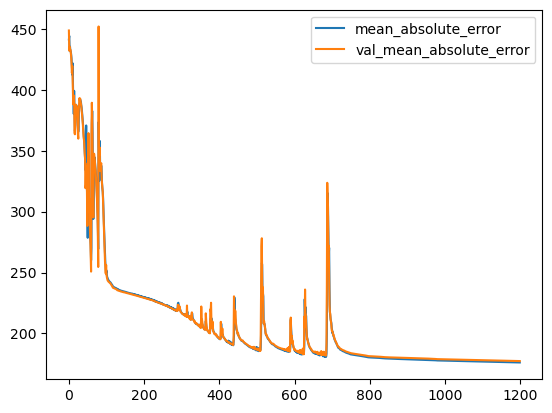

In [44]:
# аналогично можно посмотреть и на значения метрик
plt.plot(history.history['mean_absolute_error'] + history2.history['mean_absolute_error'] +
         history3.history['mean_absolute_error'] + history4.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'] + history2.history['val_mean_absolute_error']
         + history3.history['val_mean_absolute_error'] + history4.history['val_mean_absolute_error'])
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
plt.show()

Мы видим, что модель уже вышла на плато, при этом значения лосса и ошибки на трейне и валидации практически не отличаются. Благо, данных достаточно много, а поэтому переобучения не произошло.

Значит, есть надежда, что и на тестовых данных результат будет аналогичный. 

Для того, чтобы прогнать модель на тестовых данных, используем метод `evaluate`.

In [45]:
# проверим модель на тестовой выборке
model.evaluate(x_test, y_test)

1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 110927.8984 - mean_absolute_error: 177.9201 - root_mean_squared_error: 332.7207


[129241.9296875, 177.86390686035156, 359.5023498535156]

## Оптимизаторы

Пару более-менее продвинутых алгоритмов, предшественников Adam'а: Adagrad и RMSProp.

Давайте обучим одну и ту же архитектуру на одних и тех же данных, стартуя с одних и тех же весов, но используя разные алгоритмы. 

Сделаем несколько моделей, отличающихся только алгоритмами оптимизации:

In [54]:
# чтобы не копипастить постоянно одно и то же, 
# сделаем функцию, возвращающую базовую модель
def create_basic_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(200, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
    ])

    model.load_weights('initial_weights_59-200-500-200-50-10-1.weights.h5')

    return model


# и скомпилируем её с разными оптимизаторами

# Adagrad
adagrad_model = create_basic_model()
adagrad_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0001)
)

# RMSProp
RMSProp_model = create_basic_model()
RMSProp_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
)

# Adam
adam_model = create_basic_model()
adam_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
)

Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 115703.4609
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 121433.3516
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 116264.5938
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 121004.2891
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 117209.7188
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 116532.2969
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 121333.4453
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 115605.9609
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 113999.8047
Epoch 10/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 119548.5859
Epoch 11/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 117781.0469
Epoch 12/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 131360.1875
Epoch 13/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 115752.5781
Epoch 14/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss:

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 114929.2656
Epoch 154/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 114175.3125
Epoch 155/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 113084.4219
Epoch 156/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 112660.3750
Epoch 157/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 114926.9062
Epoch 158/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 114528.3828
Epoch 159/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 114214.8359
Epoch 160/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 114320.5859
Epoch 161/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 113930.2109
Epoch 162/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 115066.7734
Epoch 163/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 114085.8125
Epoch 164/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 115068.8047
Epoch 165/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 115246.7109
Epoch 166/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/ste

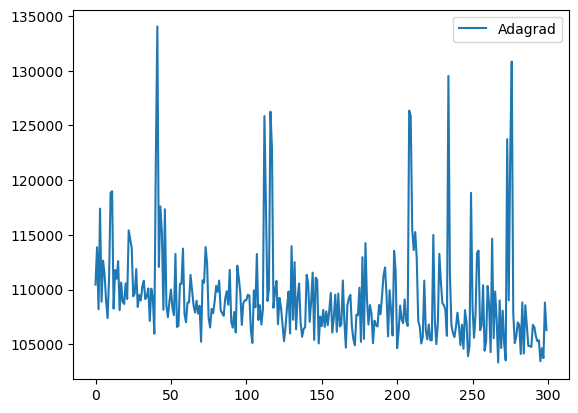

In [59]:
# обучим каждую модель в течение 400 эпох
# и нарисуем график изменения функции потерь
for m in [adam_model]:
    history = m.fit(x_train, y_train,
                    batch_size=5000,
                    epochs=300)
    plt.plot(history.history['loss'])

plt.legend(['Adagrad', 'RMSProp', 'Adam'])
plt.show()

Видим, что `Adagrad` немного скакнула вниз, но сразу же куда-то упёрлась. Скорее всего, она попала в седловую точку и её "адаптивности" не хватает, чтобы оттуда выбраться, либо lr для неё слишком большой. В общем, в любом случае нужно играть с параметрами.

У `RMSProp` всё получше: его "кобасит" (но это нормально), но он всё равно верно идёт к минимуму.

Тем не менее, `Adam` справляется быстрее всех.

В любом случае с каждой задачей и архитектурой разные оптимизаторы работают по-разному, и всегда есть смысл попробоать перебрать несколько вариантов. Но "из коробки" Adam в большинстве случаев уже неплох. 

## А что, если всё-таки не ReLU?

Мы с вами говорили о том, что зачастую ReLU оказывается лучше сигмоидальных функций из-за проблемы затухающих градиентов. Малые значения производных перемножаются, "накапливаются", веса сдвигаются меньше и обучение идёт сложнее.

Давайте попробуем заменить в нашей нейросети все функции активации на сигмоиду и сами посмотрим, как будет идти обучение.

In [57]:
# сравним, как будут обучаться модели с релу и сигмоидой

relu_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(200, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
    ])

sigma_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(200, activation='sigmoid', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(500, activation='sigmoid'),
        tf.keras.layers.Dense(200, activation='sigmoid'),
        tf.keras.layers.Dense(50, activation='sigmoid'),
        tf.keras.layers.Dense(10, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
    ])

# загрузим им одинаковые начальные веса
relu_model.load_weights('initial_weights_59-200-500-200-50-10-1.weights.h5')
sigma_model.load_weights('initial_weights_59-200-500-200-50-10-1.weights.h5')

# и уже заранее установим сигме в несколько раз больший rl:
# если сделать такой же, как у ReLU, обучение будет идти 
# совсем черепашьими темпами
relu_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
)
sigma_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)  # сразу уже сделаем lr побольше
)

Epoch 1/400
4/4 [==============================] - 0s 73ms/step - loss: 369258.0938
Epoch 2/400
4/4 [==============================] - 0s 67ms/step - loss: 345690.7188
Epoch 3/400
4/4 [==============================] - 0s 70ms/step - loss: 349285.3125
Epoch 4/400
4/4 [==============================] - 0s 63ms/step - loss: 347266.4375
Epoch 5/400
4/4 [==============================] - 0s 63ms/step - loss: 344554.9375
Epoch 6/400
4/4 [==============================] - 0s 63ms/step - loss: 344806.9688
Epoch 7/400
4/4 [==============================] - 0s 64ms/step - loss: 344448.6875
Epoch 8/400
4/4 [==============================] - 0s 63ms/step - loss: 344348.4062
Epoch 9/400
4/4 [==============================] - 0s 63ms/step - loss: 344233.4688
Epoch 10/400
4/4 [==============================] - 0s 61ms/step - loss: 344099.8750
Epoch 11/400
4/4 [==============================] - 0s 63ms/step - loss: 344018.3438
Epoch 12/400
4/4 [==============================] - 0s 62ms/step - loss: 3

4/4 [==============================] - 0s 63ms/step - loss: 153185.7812
Epoch 193/400
4/4 [==============================] - 0s 65ms/step - loss: 152734.5625
Epoch 194/400
4/4 [==============================] - 0s 63ms/step - loss: 152276.0781
Epoch 195/400
4/4 [==============================] - 0s 65ms/step - loss: 152908.9062
Epoch 196/400
4/4 [==============================] - 0s 64ms/step - loss: 153200.5469
Epoch 197/400
4/4 [==============================] - 0s 58ms/step - loss: 155480.6719
Epoch 198/400
4/4 [==============================] - 0s 57ms/step - loss: 159516.3125
Epoch 199/400
4/4 [==============================] - 0s 59ms/step - loss: 169962.4531
Epoch 200/400
4/4 [==============================] - 0s 71ms/step - loss: 157955.2969
Epoch 201/400
4/4 [==============================] - 0s 65ms/step - loss: 154452.8594
Epoch 202/400
4/4 [==============================] - 0s 53ms/step - loss: 153975.7500
Epoch 203/400
4/4 [==============================] - 0s 55ms/step - 

4/4 [==============================] - 0s 52ms/step - loss: 142086.4844
Epoch 382/400
4/4 [==============================] - 0s 51ms/step - loss: 141336.2656
Epoch 383/400
4/4 [==============================] - 0s 53ms/step - loss: 140837.0000
Epoch 384/400
4/4 [==============================] - 0s 53ms/step - loss: 141058.4062
Epoch 385/400
4/4 [==============================] - 0s 53ms/step - loss: 139298.7656
Epoch 386/400
4/4 [==============================] - 0s 53ms/step - loss: 138120.1562
Epoch 387/400
4/4 [==============================] - 0s 51ms/step - loss: 136963.9844
Epoch 388/400
4/4 [==============================] - 0s 53ms/step - loss: 136531.4844
Epoch 389/400
4/4 [==============================] - 0s 70ms/step - loss: 136510.7188
Epoch 390/400
4/4 [==============================] - 0s 53ms/step - loss: 136248.4688
Epoch 391/400
4/4 [==============================] - 0s 56ms/step - loss: 135803.6875
Epoch 392/400
4/4 [==============================] - 0s 69ms/step - 

4/4 [==============================] - 0s 62ms/step - loss: 246913.7656
Epoch 78/400
4/4 [==============================] - 0s 61ms/step - loss: 245641.9375
Epoch 79/400
4/4 [==============================] - 0s 63ms/step - loss: 244390.4375
Epoch 80/400
4/4 [==============================] - 0s 59ms/step - loss: 243162.3750
Epoch 81/400
4/4 [==============================] - 0s 63ms/step - loss: 241953.0312
Epoch 82/400
4/4 [==============================] - 0s 63ms/step - loss: 240765.6250
Epoch 83/400
4/4 [==============================] - 0s 61ms/step - loss: 239593.4688
Epoch 84/400
4/4 [==============================] - 0s 65ms/step - loss: 238442.4688
Epoch 85/400
4/4 [==============================] - 0s 61ms/step - loss: 237309.5156
Epoch 86/400
4/4 [==============================] - 0s 62ms/step - loss: 236197.6719
Epoch 87/400
4/4 [==============================] - 0s 61ms/step - loss: 235103.5469
Epoch 88/400
4/4 [==============================] - 0s 60ms/step - loss: 23403

4/4 [==============================] - 0s 55ms/step - loss: 184023.1562
Epoch 268/400
4/4 [==============================] - 0s 57ms/step - loss: 184014.5000
Epoch 269/400
4/4 [==============================] - 0s 57ms/step - loss: 184006.2031
Epoch 270/400
4/4 [==============================] - 0s 56ms/step - loss: 183998.4688
Epoch 271/400
4/4 [==============================] - 0s 56ms/step - loss: 183990.7188
Epoch 272/400
4/4 [==============================] - 0s 57ms/step - loss: 183983.5469
Epoch 273/400
4/4 [==============================] - 0s 54ms/step - loss: 183976.4531
Epoch 274/400
4/4 [==============================] - 0s 56ms/step - loss: 183969.7969
Epoch 275/400
4/4 [==============================] - 0s 56ms/step - loss: 183963.4844
Epoch 276/400
4/4 [==============================] - 0s 54ms/step - loss: 183957.3906
Epoch 277/400
4/4 [==============================] - 0s 53ms/step - loss: 183951.2188
Epoch 278/400
4/4 [==============================] - 0s 55ms/step - 

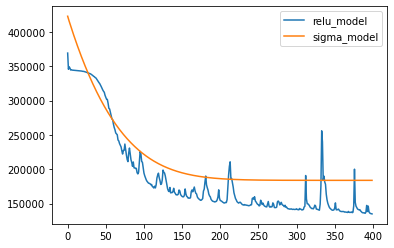

In [26]:
# обучим обе модели в течение 400 эпох
# и посмотрим на динамику лосса
for m in [relu_model, sigma_model]:
    history = m.fit(x_train, y_train,
                    batch_size=50000,
                    epochs=400)
    plt.plot(history.history['loss'])

plt.legend(['relu_model', 'sigma_model'])
plt.show()

Как можно видеть, нейросеть с сигмоидой обучается куда менее "охотно" (и это-то при разнице lr в 100 раз!), а потом и вовсе застревает на месте. 

Есть немало способов попробовать побороться с этим, но проще всего банально использовать другие функции активации.